In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import nibabel as nib
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import os
from reload_recursive import reload_recursive
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
import sys
import re

from mri_data import file_manager as fm

### Paths and Config

In [3]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
cp_data_dir = Path("/home/srs-9/Projects/ms_mri/analysis/paper1/data0")
showfigs = False
pd.options.display.precision = 3

In [4]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda x: x / df_thomas['THALAMUS_1'])
df_thomas_norm = df_thomas_norm.drop("THALAMUS_1", axis=1)
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")
cols_orig = df_thomas.columns

In [5]:
new_index = []
for col in df_thomas.columns:
    new_index.append(int(re.match(r".+_(\d+)$", col)[1]))

df_structs = pd.DataFrame({'struct': df_thomas.columns}, index=new_index)

In [6]:
df = pd.read_csv(cp_data_dir / "t1_aschoplex_data_full.csv", index_col="subid")
df_full = df.copy()
df_tmp = pd.read_csv(cp_data_dir / "t1_data_full.csv", index_col="subid")
df['pineal_volume'] = df_tmp['pineal_volume']
df['pituitary_volume'] = df_tmp['pituitary_volume']
df = pd.concat((df, pd.get_dummies(df["sex"], dtype="int")), axis=1)

keep_cols = ["choroid_volume", "pineal_volume", "pituitary_volume", "Female", "age", "tiv"]
df = df[keep_cols]
df_z = df.apply(stats.zscore, nan_policy="omit")

In [11]:
model_data = df_z.join(df_thomas_z)
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

for struct in df_thomas_z.columns:
    formula = f"choroid_volume ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

print(regression_results)

        struct   coef      pvals      p_fdr  coef_sig
1   THALAMUS_1 -0.469  6.512e-23  4.775e-22    -0.469
12    MD_Pf_12 -0.452  3.106e-24  3.417e-23    -0.452
8        Pul_8 -0.451  2.542e-24  3.417e-23    -0.451
11       CM_11 -0.408  1.207e-18  6.641e-18    -0.408
10      MGN_10 -0.387  4.997e-16  2.199e-15    -0.387
28      Cla_28 -0.368  8.555e-14  2.689e-13    -0.368
9        LGN_9 -0.327  7.602e-15  2.787e-14    -0.327
31      Put_31 -0.285  4.706e-08  1.035e-07    -0.285
26      Acc_26 -0.277  3.502e-08  8.562e-08    -0.277
7        VPL_7 -0.277  4.727e-09  1.300e-08    -0.277
32       RN_32 -0.269  3.324e-07  5.625e-07    -0.269
6        VLP_6 -0.266  1.368e-07  2.508e-07    -0.266
2         AV_2 -0.247  1.171e-07  2.342e-07    -0.247
13       Hb_13 -0.183  2.096e-05  3.294e-05    -0.183
29      GPe_29 -0.117  2.461e-02  3.610e-02    -0.117
33       GP_33 -0.112  3.264e-02  4.488e-02    -0.112
4         VA_4 -0.107  4.778e-02  5.840e-02     0.000
5        VLa_5 -0.103  4.736

### Overlay betas on label map

In [9]:
thomas_dir = Path("/mnt/h/srs-9/hips-thomas/sub1001-20170215")
thomL_file = thomas_dir / "left/thomasfull_L.nii.gz"
thomL_img = nib.load(thomL_file)
thomR_file = thomas_dir / "right/thomasfull_R.nii.gz"
thomR_img = nib.load(thomR_file)
thom = thomL_img.get_fdata() + thomR_img.get_fdata()

In [12]:
beta_map = np.zeros_like(thom)
for lab in np.unique(thom):
    try:
        beta_map[thom==lab] = regression_results.loc[lab, 'coef_sig']
    except KeyError:
        print(lab)
        continue

betamap_img = nib.Nifti1Image(beta_map, thomL_img.affine)
nib.save(betamap_img, thomas_dir/"betamap_sig.nii.gz")

0.0


### Use normed volumes

In [10]:
model_data = df_z.join(df_thomas_norm_z)
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

for struct in df_thomas_norm_z.columns:
    formula = f"choroid_volume ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

print(regression_results)

      struct   coef      pvals      p_fdr  coef_sig
8      Pul_8 -0.307  1.721e-13  6.022e-13    -0.307
9      LGN_9 -0.131  1.017e-03  1.525e-03    -0.131
2       AV_2 -0.111  1.312e-02  1.621e-02    -0.111
12  MD_Pf_12 -0.107  9.174e-03  1.284e-02    -0.107
11     CM_11 -0.004  9.303e-01  9.303e-01     0.000
28    Cla_28  0.061  1.520e-01  1.596e-01     0.000
13     Hb_13  0.069  9.988e-02  1.104e-01     0.000
7      VPL_7  0.101  1.537e-02  1.793e-02     0.101
10    MGN_10  0.104  1.244e-02  1.621e-02     0.104
26    Acc_26  0.203  1.767e-06  2.854e-06     0.203
34    Amy_34  0.261  9.178e-10  1.606e-09     0.261
31    Put_31  0.281  3.760e-11  7.178e-11     0.281
27    Cau_27  0.282  3.422e-12  7.985e-12     0.282
32     RN_32  0.283  2.867e-11  6.020e-11     0.283
29    GPe_29  0.310  9.869e-13  2.591e-12     0.310
6      VLP_6  0.325  1.205e-14  6.328e-14     0.325
14    MTT_14  0.329  9.418e-15  6.328e-14     0.329
33     GP_33  0.333  1.298e-13  5.451e-13     0.333
30    GPi_30

In [ ]:
beta_map = np.zeros_like(thom)
for lab in np.unique(thom):
    try:
        beta_map[thom==lab] = regression_results.loc[lab, 'coef']
    except KeyError:
        print(lab)
        continue

betamap_img = nib.Nifti1Image(beta_map, thomL_img.affine)
nib.save(betamap_img, thomas_dir/"betamap_normed.nii.gz")

0.0


### Control for thalamus volume

In [85]:
model_data = df_z.join(df_thomas_z)
covariates = "age + Female + tiv + THALAMUS_1"

pvals = {}
coefs = {}

structs = df_thomas_z.columns[~df_thomas_z.columns.isin(["THALAMUS_1"])]
for struct in structs:
    formula = f"choroid_volume ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

print(regression_results)

      struct   coef      pvals      p_fdr  coef_sig
8      Pul_8 -0.319  4.603e-03  1.208e-02    -0.319
12  MD_Pf_12 -0.300  3.092e-03  9.276e-03    -0.300
11     CM_11 -0.181  2.903e-03  9.276e-03    -0.181
28    Cla_28 -0.130  2.275e-02  5.309e-02     0.000
9      LGN_9 -0.098  6.239e-02  1.310e-01     0.000
10    MGN_10 -0.097  1.427e-01  2.306e-01     0.000
31    Put_31 -0.053  3.358e-01  4.148e-01     0.000
13     Hb_13 -0.046  2.720e-01  3.569e-01     0.000
26    Acc_26 -0.045  4.013e-01  4.435e-01     0.000
32     RN_32 -0.008  8.860e-01  8.860e-01     0.000
29    GPe_29  0.023  6.432e-01  6.754e-01     0.000
33     GP_33  0.043  3.856e-01  4.435e-01     0.000
34    Amy_34  0.052  2.069e-01  3.104e-01     0.000
2       AV_2  0.064  2.543e-01  3.560e-01     0.000
27    Cau_27  0.079  1.004e-01  1.758e-01     0.000
30    GPi_30  0.079  9.106e-02  1.738e-01     0.000
14    MTT_14  0.159  4.111e-04  1.726e-03     0.159
5      VLa_5  0.251  9.261e-06  6.482e-05     0.251
7      VPL_7

In [86]:
beta_map = np.zeros_like(thom)
for lab in np.unique(thom):
    try:
        beta_map[thom==lab] = regression_results.loc[lab, 'coef_sig']
    except KeyError:
        print(lab)
        continue

betamap_img = nib.Nifti1Image(beta_map, thomL_img.affine)
nib.save(betamap_img, thomas_dir/"betamap_control_sig.nii.gz")

0.0


In [72]:
model_data = df_z.join(df_thomas_z)
outcomes = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1"])]
covariates = "age + Female + tiv + THALAMUS_1"

cols_orig2 = cols_orig[~cols_orig.isin(["1-THALAMUS"])]

pvals = {}
coefs = {}

for outcome in outcomes:
    formula = f"{outcome} ~ choroid_volume + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[outcome] = res.pvalues['choroid_volume']
    coefs[outcome] = res.params['choroid_volume']

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
print(regression_results)

           coef      pvals      p_fdr
CM_11    -0.101  2.903e-03  9.276e-03
Cla_28   -0.082  2.275e-02  5.309e-02
LGN_9    -0.073  6.239e-02  1.310e-01
MD_Pf_12 -0.060  3.092e-03  9.276e-03
Hb_13    -0.054  2.720e-01  3.569e-01
Pul_8    -0.052  4.603e-03  1.208e-02
MGN_10   -0.046  1.427e-01  2.306e-01
Put_31   -0.036  3.358e-01  4.148e-01
Acc_26   -0.032  4.013e-01  4.435e-01
RN_32    -0.005  8.860e-01  8.860e-01
GPe_29    0.020  6.432e-01  6.754e-01
GP_33     0.036  3.856e-01  4.435e-01
AV_2      0.042  2.543e-01  3.560e-01
Amy_34    0.063  2.069e-01  3.104e-01
Cau_27    0.071  1.004e-01  1.758e-01
GPi_30    0.074  9.106e-02  1.738e-01
VPL_7     0.098  4.088e-04  1.726e-03
VLP_6     0.131  4.734e-08  4.970e-07
VLa_5     0.159  9.261e-06  6.482e-05
MTT_14    0.160  4.111e-04  1.726e-03
VA_4      0.189  3.023e-09  6.348e-08


### Estimate exposure of each substructure to CSF

Got aseg from fastsurfer. had to reregister it back to original space. extracted the ventricles only (label indices [here](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT)). Then used c3d -sdt to get the signed distance transform, absed then binned to get below:

In [60]:
from sklearn.cluster import HDBSCAN
from scipy import ndimage
from scipy.spatial import distance

In [67]:
aseg_file = "/mnt/h/srs-9/hips-thomas/sub1001-20170215/aseg-sdt-bin.nii.gz"
aseg = nib.load(aseg_file).get_fdata()
ventricle_points = np.argwhere(aseg==0)

In [54]:
thomas_dir = Path("/mnt/h/srs-9/hips-thomas/sub1001-20170215")
thomL_file = thomas_dir / "left/thomasfull_L.nii.gz"
thomL_img = nib.load(thomL_file)
thomL = thomL_img.get_fdata()

thomR_file = thomas_dir / "right/thomasfull_R.nii.gz"
thomR_img = nib.load(thomR_file)
thomR = thomR_img.get_fdata()
thom = thomL_img.get_fdata() + thomR_img.get_fdata()

In [70]:
def exposure(centroid, point_set):
    total = 0
    for point in point_set:
        total = total + 1 / (distance.euclidean(centroid, point))**2
    return total

In [82]:
df_exposure = df_structs.copy()
for ind in np.unique(thomL):
    struct_pts = thomL.copy()
    struct_pts[thomL!=ind] = 0
    struct_pts[thomL==ind] = 1

    centroid = ndimage.center_of_mass(struct_pts)
    df_exposure.loc[ind, 'exposure'] = exposure(centroid, ventricle_points)

In [84]:
exposure_map = np.zeros_like(thom)
for lab in np.unique(thom):
    if lab == 0:
        continue
    try:
        if df_exposure.loc[lab, 'exposure'] is None:
            print(lab)
            continue
        exposure_map[thom==lab] = df_exposure.loc[lab, 'exposure']
    except KeyError:
        print(lab)
        continue

exposure_map_img = nib.Nifti1Image(exposure_map, thomL_img.affine)
nib.save(exposure_map_img, thomas_dir/"exposure_map.nii.gz")

In [ ]:
np.unique()

In [77]:
df_exposure['coef'] = regression_results['coef']

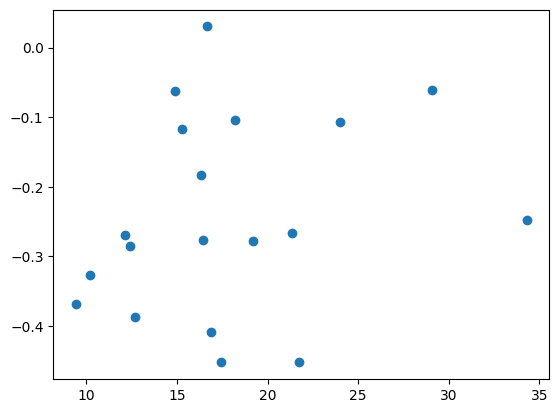

In [78]:
plt.scatter(df_exposure['exposure'], df_exposure['coef'])

In [ ]:
centroid_coords = [round(coord) for coord in centroid]
test = thom.copy()
test[*centroid_coords] = 60
test_img = nib.Nifti1Image(test, thomL_img.affine)
nib.save(test_img, thomas_dir/"check.nii.gz")